In [1]:
%load_ext tensorboard
%pylab inline

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, from_numpy

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def norm(data, hi=None, lo=None):
    hi = np.max(data) if not hi else hi
    lo = np.min(data) if not lo else lo
    if hi-lo == 0:
        return 0, hi, lo
    y = (data-lo)/(hi-lo)
    return y, hi, lo

def reverse_norm(y, hi, lo):
    x = y*(hi-lo)+lo
    return x

def zscore(data, mu=None, sigma=None):
    # z = (x-μ)/σ
    mu = np.mean(data) if not mu else mu
    sigma = np.std(data) if not sigma else sigma
    if sigma == 0:
        return 0, mu, 0
    return (data-mu)/sigma, mu, sigma

def reverse_zscore(z, mu, sigma):
    # x = (zσ)+μ
    x = (z*sigma)+mu
    return x

# Load Data

In [3]:
data = pd.read_csv('data.csv', header=0)
data

,noise,sine_1,sine_2,combined
0,-0.545357,6.279052e-02,3.141572e-02,9.420624e-02
1,0.151303,1.253332e-01,6.283020e-02,1.881634e-01
2,0.825299,1.873813e-01,9.424220e-02,2.816235e-01
3,-0.486808,2.486899e-01,1.256505e-01,3.743404e-01
4,0.334807,3.090170e-01,1.570538e-01,4.660708e-01
...,...,...,...,...
4995,0.029877,-2.486899e-01,-1.256505e-01,-3.743404e-01
4996,0.687034,-1.873813e-01,-9.424220e-02,-2.816235e-01
4997,0.368473,-1.253332e-01,-6.283020e-02,-1.881634e-01
4998,0.623531,-6.279052e-02,-3.141572e-02,-9.420624e-02


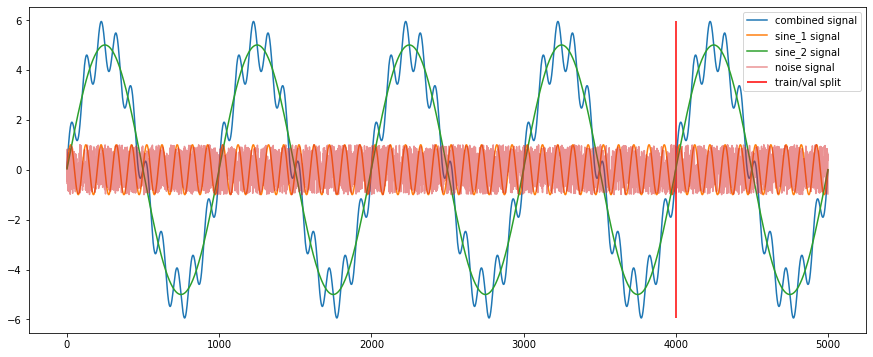

In [4]:
figsize(15,6)
idx_val_split = int(0.8 * data.shape[0])
plot(data['combined'], label='combined signal')
plot(data['sine_1'], label='sine_1 signal')
plot(data['sine_2'], label='sine_2 signal')
plot(data['noise'], alpha=0.5, label='noise signal')
vlines(idx_val_split, ymin=np.min(data['combined']), ymax=np.max(data['combined']), color='r', label='train/val split')
legend()
show()

# Transform & Normalize Data

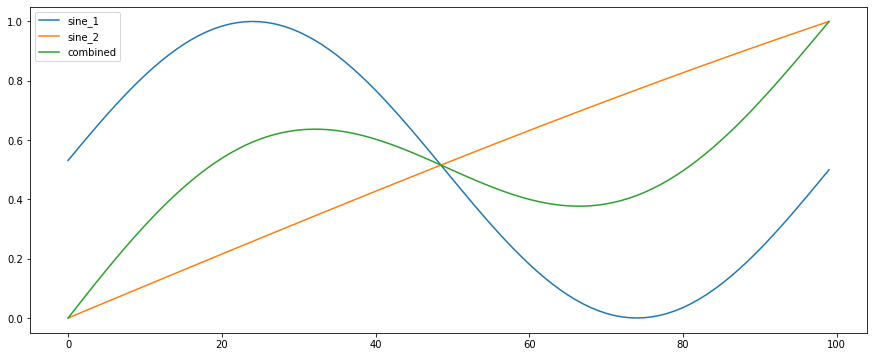

In [5]:
figsize(15,6)
window_size = 100
step_size = 1

plot(norm(data['sine_1'][:window_size])[0], label='sine_1')
plot(norm(data['sine_2'][:window_size])[0], label='sine_2')
plot(norm(data['combined'][:window_size])[0], label='combined')
legend()
show()

In [6]:
idx_front = 0
idx_rear = window_size
features_x = ['sine_1', 'sine_2', 'noise']
feature_y = 'combined'

tr_data_windows_size = int(np.ceil((data['sine_1'][:idx_val_split].shape[0]-window_size-1)/step_size))
tr_data_windows = np.empty((tr_data_windows_size, len(features_x), window_size))
tr_data_windows_y = np.zeros(tr_data_windows_size)

i = 0
pbar = tqdm(total=tr_data_windows_size-1, initial=i)
while idx_rear + 1 < data['sine_1'][:idx_val_split].shape[0]:
    # create x data windows
    for j, feature in enumerate(features_x):
        _data_window, _hi, _lo = norm(data[feature][idx_front:idx_rear])
        tr_data_windows[i][j] = _data_window
        
    # create y along same normalized scale
    _, hi, lo = norm(data[feature_y][idx_front:idx_rear])
    _y = norm(data[feature_y][idx_rear], hi, lo)[0]
    tr_data_windows_y[i] = _y
    
    idx_front = idx_front + step_size
    idx_rear = idx_front + window_size
    i += 1
    pbar.update(1)
pbar.close()

# reshape input into [samples, timesteps, features]
tr_data_size = tr_data_windows.shape[0]
tr_input_seq = tr_data_windows.swapaxes(1,2)

3899it [00:05, 671.72it/s]                          


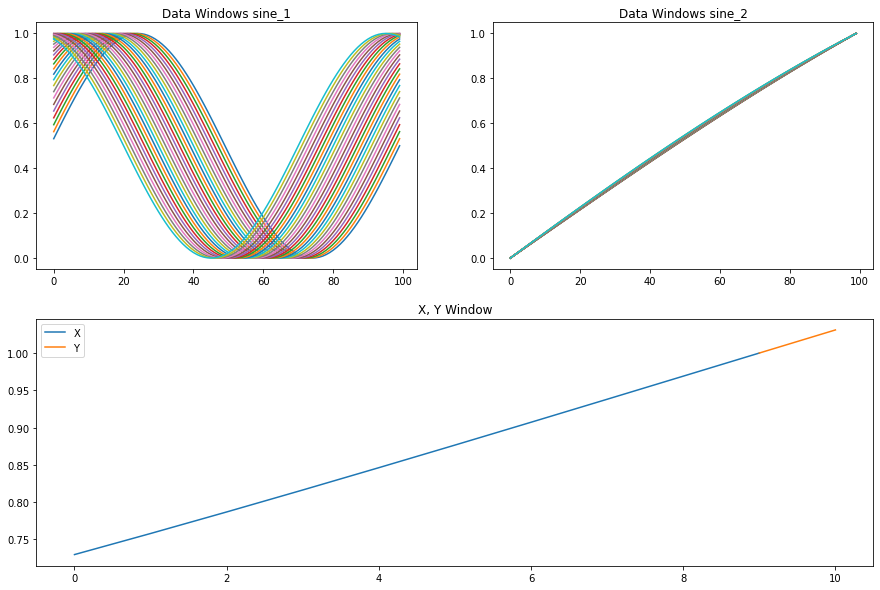

In [7]:
figsize(15,10)
subplot(2,2,1)
for i in range(30):
    plot(tr_input_seq[i,:,0])
title('Data Windows sine_1')

subplot(2,2,2)
for i in range(30):
    plot(tr_input_seq[i,:,1])
title('Data Windows sine_2')

subplot(2,1,2)
# test prediction Y with visual
p = [None for x in range(9)]
p.append(norm(data['combined'][:window_size])[0].iloc[-1])
p.append(tr_data_windows_y[0])
plot(list(norm(data['combined'][:window_size])[0][-10:]), label='X')
plot(p, label='Y')
legend()
title('X, Y Window')
show()

# Model Run

In [8]:
float_precision_bits = 32
bits_in_MB = 8e6

def calc_input_memory(input_shape):
    input_bits = np.prod(input_shape, dtype='int64')*float_precision_bits
    return input_bits / bits_in_MB

def calc_model_memory(model):
    mods = list(model.modules())
    sizes = []
    for i in range(1,len(mods)):
        m = mods[i]
        p = list(m.parameters())
        for j in range(len(p)):
            sizes.append(np.array(p[j].size()))

    total_bits = 0
    for i in range(len(sizes)):
        s = sizes[i]
        bits = np.prod(np.array(s), dtype='int64')*float_precision_bits
        total_bits += bits
    return total_bits / bits_in_MB

def calc_model_params(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [9]:
class Data(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(self.x)

In [10]:
from mvtae_model import MVTAEModel

hidden_vector_size = 64
hidden_alpha_size = 16
batch_size = 8

dataset = Data(
    x=from_numpy(tr_input_seq).float(),
    y=from_numpy(tr_data_windows_y).float()
)

data_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size
)

model = MVTAEModel(model_save_path='./',
                   seq_len=tr_input_seq.shape[1],
                   in_data_dims=tr_input_seq.shape[2],
                   out_data_dims=tr_input_seq.shape[2],
                   model_name='mvtae_model',
                   hidden_vector_size=hidden_vector_size,
                   hidden_alpha_size=hidden_alpha_size,
                   dropout_p=0.1,
                   optim_lr=0.0001)

print('-'*30)
print('Data Batch Size:\t%.2fMB' % calc_input_memory((batch_size, tr_input_seq.shape[1], tr_input_seq.shape[2])))
print('Model Size:\t\t%.2fMB' % calc_model_memory(model))
print('Model Parameters:\t%d' % calc_model_params(model))
print('-'*30)
print('Data Size:\t\t', len(dataset))
print('Batches per Epoch:\t', int(len(dataset)/tr_input_seq.shape[0]))

Using cuda
Using GPU: Tesla V100-DGXS-16GB
------------------------------
Data Batch Size:	0.01MB
Model Size:		0.21MB
Model Parameters:	52468
------------------------------
Data Size:		 3899
Batches per Epoch:	 1


In [11]:
tensorboard_folder = './tensorboard'
%tensorboard --port 6006 --logdir $tensorboard_folder

In [12]:
model.fit(data_loader, epochs=250, start_epoch=0, verbose=True)

100%|██████████| 250/250 [19:55<00:00,  4.78s/it]

Best epoch: 219 | loss 0.028108207508921623


In [13]:
model.load_state_dict(torch.load('mvtae_model_best.pth'))

<All keys matched successfully>

# Hidden State Vector Visualisation

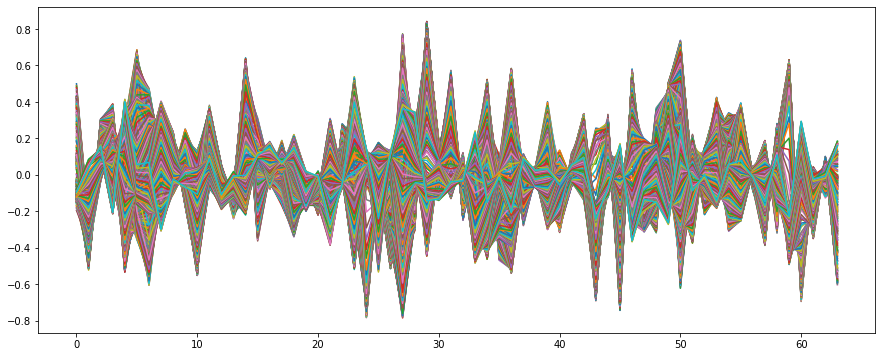

In [14]:
model.eval()
figsize(15,6)
zoom_lim = 400 # limit num of hidden vector examples to show
hidden_state_vector, decoder_output, alpha_output = model(from_numpy(tr_input_seq[:zoom_lim]).float())

# visualise hidden vector
for i in range(tr_input_seq[:zoom_lim].shape[0]):
    plot(hidden_state_vector[0, i].detach().cpu())
show()

# Decoder Target Recreation

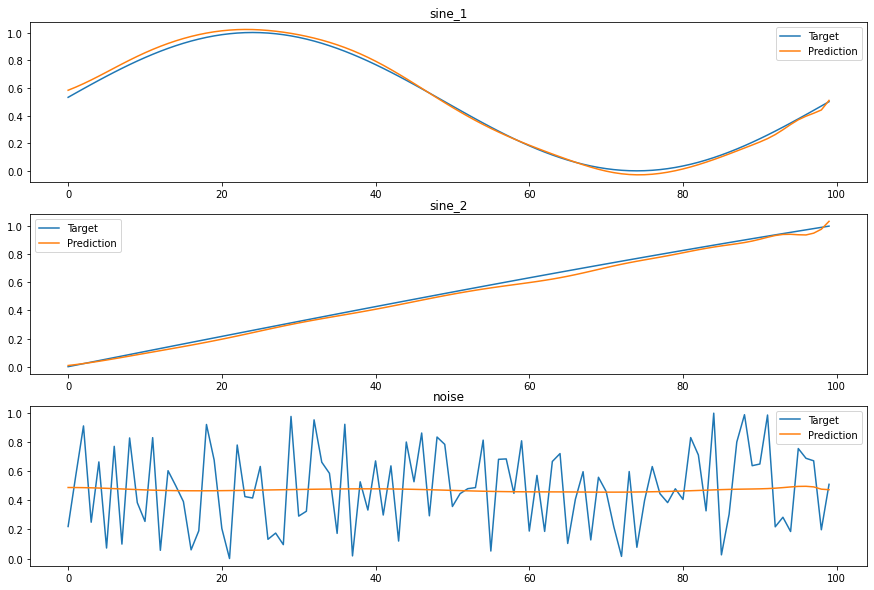

In [15]:
model.eval()
figsize(15,10)
idx = 0
y_in = tr_input_seq[idx].reshape(1, window_size, tr_input_seq.shape[2])
hidden_state_vector, decoder_output, alpha_output = model(from_numpy(y_in).float())

subplot(3,1,1)
plot(tr_input_seq[idx,:,0], label='Target')
plot(decoder_output[0,:,0].detach().cpu().numpy()[::-1], label='Prediction')
title('sine_1')
legend()

subplot(3,1,2)
plot(tr_input_seq[idx,:,1], label='Target')
plot(decoder_output[0,:,1].detach().cpu().numpy()[::-1], label='Prediction')
title('sine_2')
legend()

subplot(3,1,3)
plot(tr_input_seq[idx,:,2], label='Target')
plot(decoder_output[0,:,2].detach().cpu().numpy()[::-1], label='Prediction')
title('noise')
legend()
show()

# Alpha Target Branch Prediction

### Error/Accuracy Metrics ###
MSE:	 0.0010554455800590521
MAE:	 0.023022483376210708
R²:	 0.9935462829031128


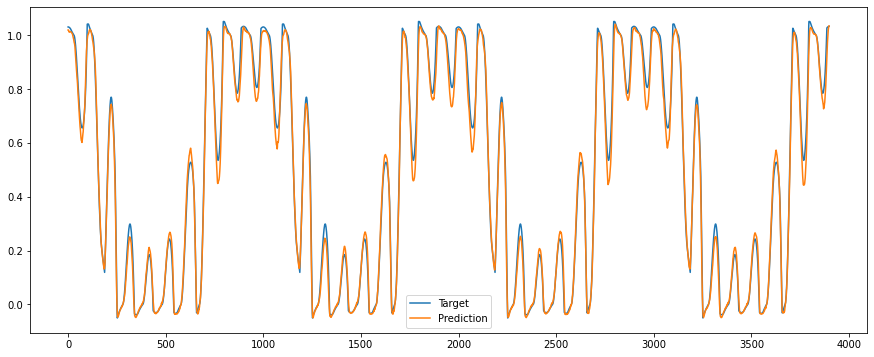

In [16]:
model.eval()
figsize(15,6)
_,_ , alpha_output = model(from_numpy(tr_input_seq).float())
alpha_output = alpha_output.flatten().detach().cpu().numpy()

print('### Error/Accuracy Metrics ###')
print('MSE:\t', mean_squared_error(tr_data_windows_y, alpha_output))
print('MAE:\t', mean_absolute_error(tr_data_windows_y, alpha_output))
print('R²:\t', r2_score(tr_data_windows_y, alpha_output))

plot(tr_data_windows_y, label='Target')
plot(alpha_output, label='Prediction')
legend()
show()

# Full Dataset Absolute Construction-Prediction Run

100%|██████████| 5000/5000 [00:20<00:00, 238.57it/s]


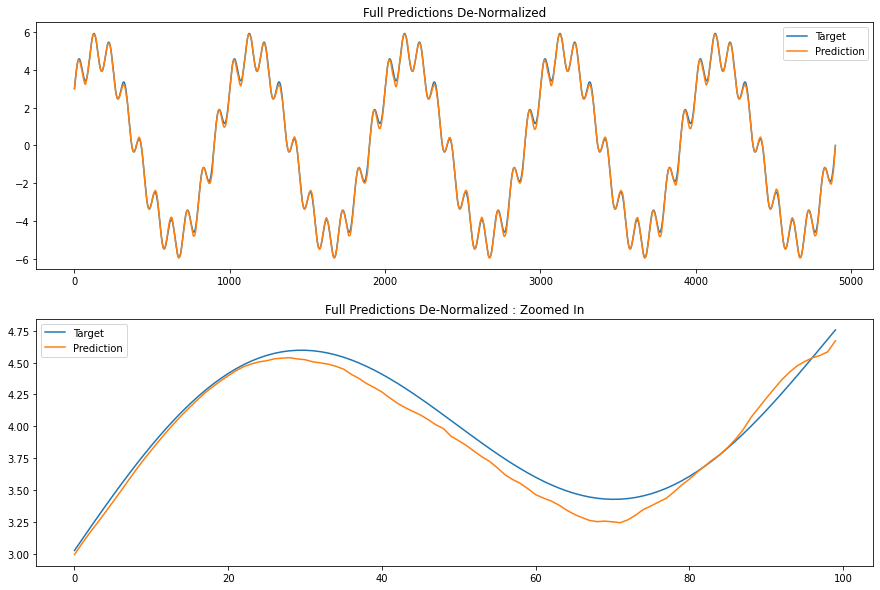

In [17]:
model.eval()
true = []
pred = []
for i in tqdm(range(data.shape[0])):
    if i < window_size:
        continue
    data_window = data[i-window_size:i]
    input_seq = np.zeros((1, window_size, len(features_x)))
    
    for j, feature in enumerate(features_x):
        _data_window, _, _= norm(data_window[feature])
        input_seq[0,:,j] = _data_window
    _, hi, lo = norm(data_window[feature_y])
    
    x_hidden_vector, decoder_output, alpha_output = model(from_numpy(input_seq).float())
    abs_pred = reverse_norm(alpha_output.squeeze().detach().cpu().numpy(), hi, lo)
    
    true.append(data[feature_y][i])
    pred.append(abs_pred)

figsize(15,10)
subplot(2,1,1)
plot(true, label='Target')
plot(pred, label='Prediction')
title('Full Predictions De-Normalized')
legend()

subplot(2,1,2)
zoom = 100
plot(true[:zoom], label='Target')
plot(pred[:zoom], label='Prediction')
title('Full Predictions De-Normalized : Zoomed In')
legend()
show()